# COMPREHENSIVE DATA EXPLORATION WITH PYTHON

I tried to learn how to swim before jumping into the water.

what we are doing in this kernel is something like this:

1. **Understand the problem**. We'll look at each variable and do a philosophical analysis of their meaning and importance for this problem.
2. **Univariable study**. We'll just focus on the dependent variable ('SalePrice') and try to know a little bit more about it.
3. **Multivariate study**. We'll try to understand how the dependent variable and independent variables relate.
4. **Basic cleaning**. We'll clean the dataset and handle the missing data, outliers, and categorical variables.
5. **Test assumptions**. We'll check if our data meet the assumptions required by most multivariate techniques.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

pd.options.display.max_columns = 100
import warnings
warnings.filterwarnings("ignore")

In [2]:
df_train = pd.read_csv('../../data/train.csv')
df_test = pd.read_csv('../../data/test.csv')

## Overview

- There are 1460 instances of training data and 1460 of test data. Total number of attributes equals 81, of which 36 is quantitative + 43 categorical + 1 Id + SalePrice (label).

- **Quantitative**: 1stFlrSF, 2ndFlrSF, 3SsnPorch, BedroomAbvGr, BsmtFinSF1, BsmtFinSF2, BsmtFullBath, BsmtHalfBath, BsmtUnfSF, EnclosedPorch, Fireplaces, FullBath, GarageArea, GarageCars, GarageYrBlt, GrLivArea, HalfBath, KitchenAbvGr, LotArea, LotFrontage, LowQualFinSF, MSSubClass, MasVnrArea, MiscVal, MoSold, OpenPorchSF, OverallCond, OverallQual, PoolArea, ScreenPorch, TotRmsAbvGrd, TotalBsmtSF, WoodDeckSF, YearBuilt, YearRemodAdd, YrSold

- **Qualitative**: Alley, BldgType, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, BsmtQual, CentralAir, Condition1, Condition2, Electrical, ExterCond, ExterQual, Exterior1st, Exterior2nd, Fence, FireplaceQu, Foundation, Functional, GarageCond, GarageFinish, GarageQual, GarageType, Heating, HeatingQC, HouseStyle, KitchenQual, LandContour, LandSlope, LotConfig, LotShape, MSZoning, MasVnrType, MiscFeature, Neighborhood, PavedDrive, PoolQC, RoofMatl, RoofStyle, SaleCondition, SaleType, Street, Utilities,

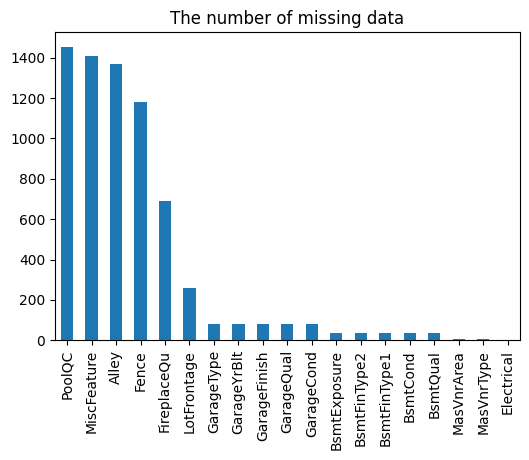

In [3]:
# Check missing data 
missing = df_train.isnull().sum()
missing = missing[missing > 0]
missing = missing.sort_values(ascending=False)

ax = missing.plot.bar(
    figsize = (6, 4)
)
ax.set_title("The number of missing data")

plt.show()

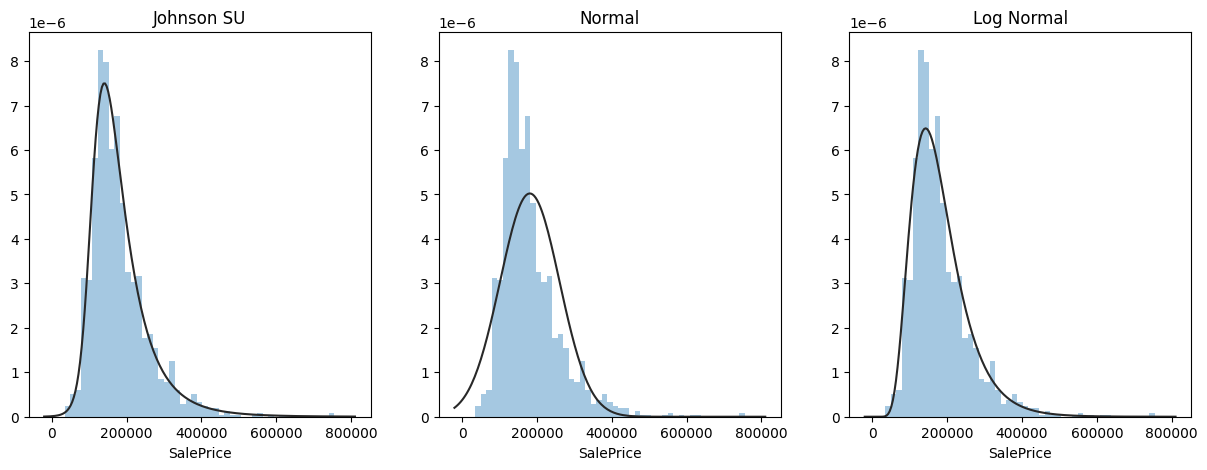

In [4]:
import scipy.stats as st
y = df_train['SalePrice']

plt.figure(figsize = (15, 5))

plt.subplot(1, 3, 1)
plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=st.johnsonsu)

plt.subplot(1, 3, 2)
plt.title('Normal')
sns.distplot(y, kde=False, fit=st.norm)

plt.subplot(1, 3, 3) 
plt.title('Log Normal')
sns.distplot(y, kde=False, fit=st.lognorm)

plt.show()

In [5]:
# The quantitative variables
quantitative = [f for f in df_train.columns if df_train.dtypes[f] != "object"]
quantitative.remove('SalePrice')
quantitative.remove('Id')

# The quanlitative variables
quanlitative = [f for f in df_train.columns if df_train.dtypes[f] == "object"]

In [6]:
# The test for normality 
test_normality = lambda x: st.shapiro(x.fillna(0))[1] < 0.01  # p_value is less than 0.01
normal = pd.DataFrame(df_train[quantitative])
normal = normal.apply(test_normality)
not normal.any()

False

### Quantitative data

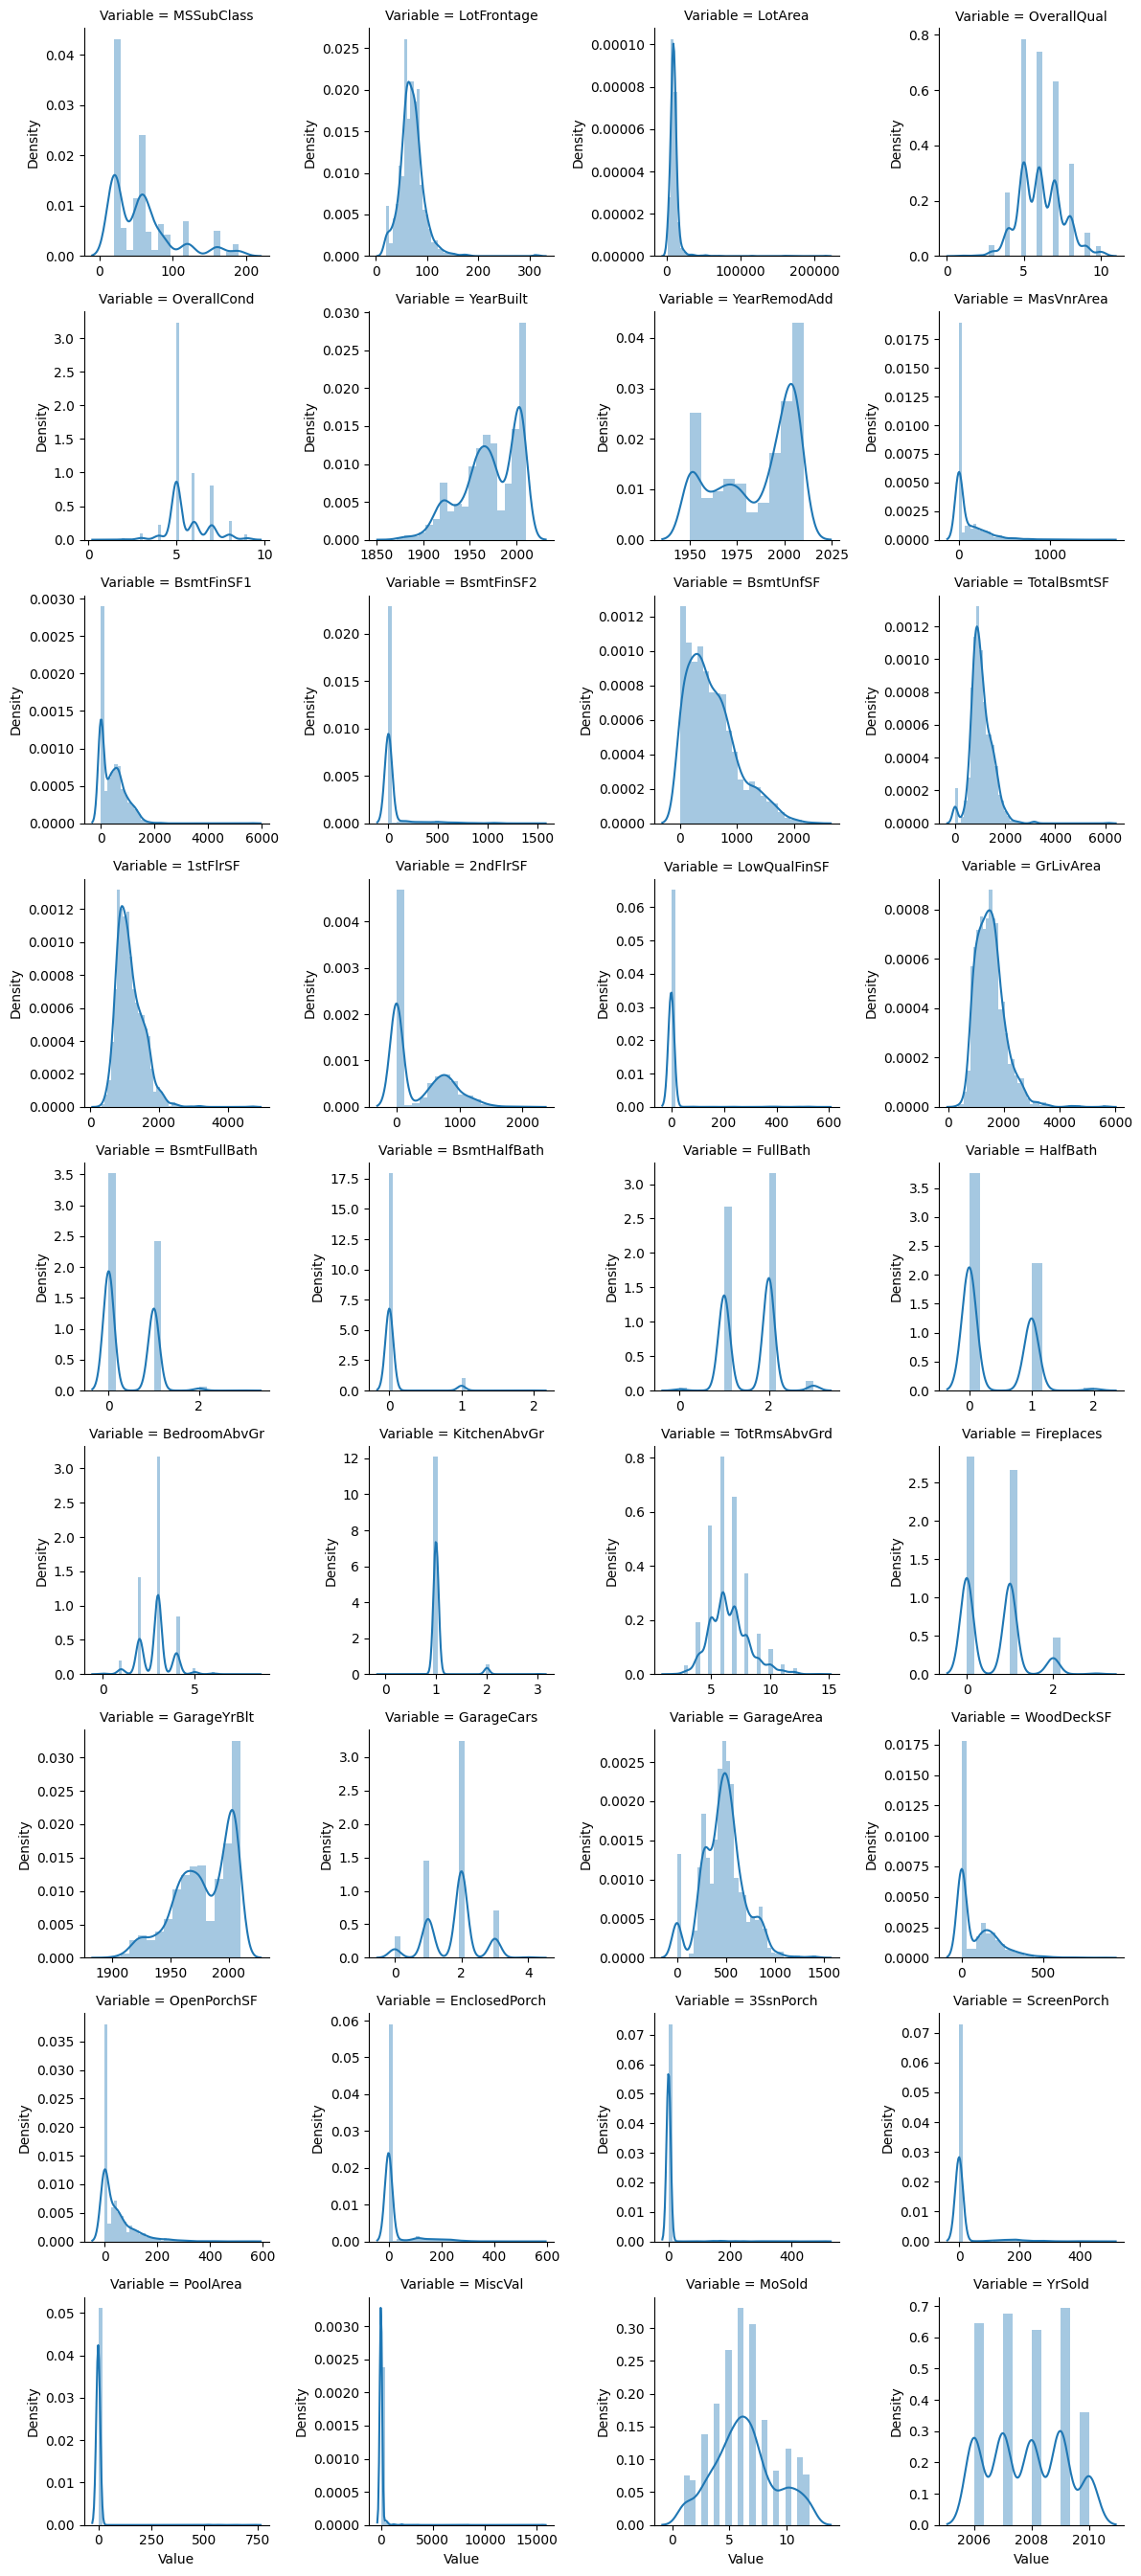

In [7]:
melted_train = pd.melt(df_train, value_vars=quantitative, value_name='Value', var_name='Variable')

# Create a FacetGrid with seaborn for plotting multiple distributions
grid = sns.FacetGrid(melted_train, col="Variable", col_wrap=4, sharex=False, sharey=False)

# Map seaborn's displot to the FacetGrid to plot the distributions
grid = grid.map(sns.distplot, "Value")

plt.show()

### Quanlitative/ Categorical data

In [8]:
# Convert quanlitative variables to categorical and handle missing values
df_train_cp = df_train.copy()

for c in quanlitative:
    df_train_cp[c] = df_train_cp[c].astype('category')
    if df_train_cp[c].isnull().any():
        df_train_cp[c] = df_train_cp[c].cat.add_categories(["MISSING"])
        df_train_cp[c] = df_train_cp[c].fillna('MISSING')

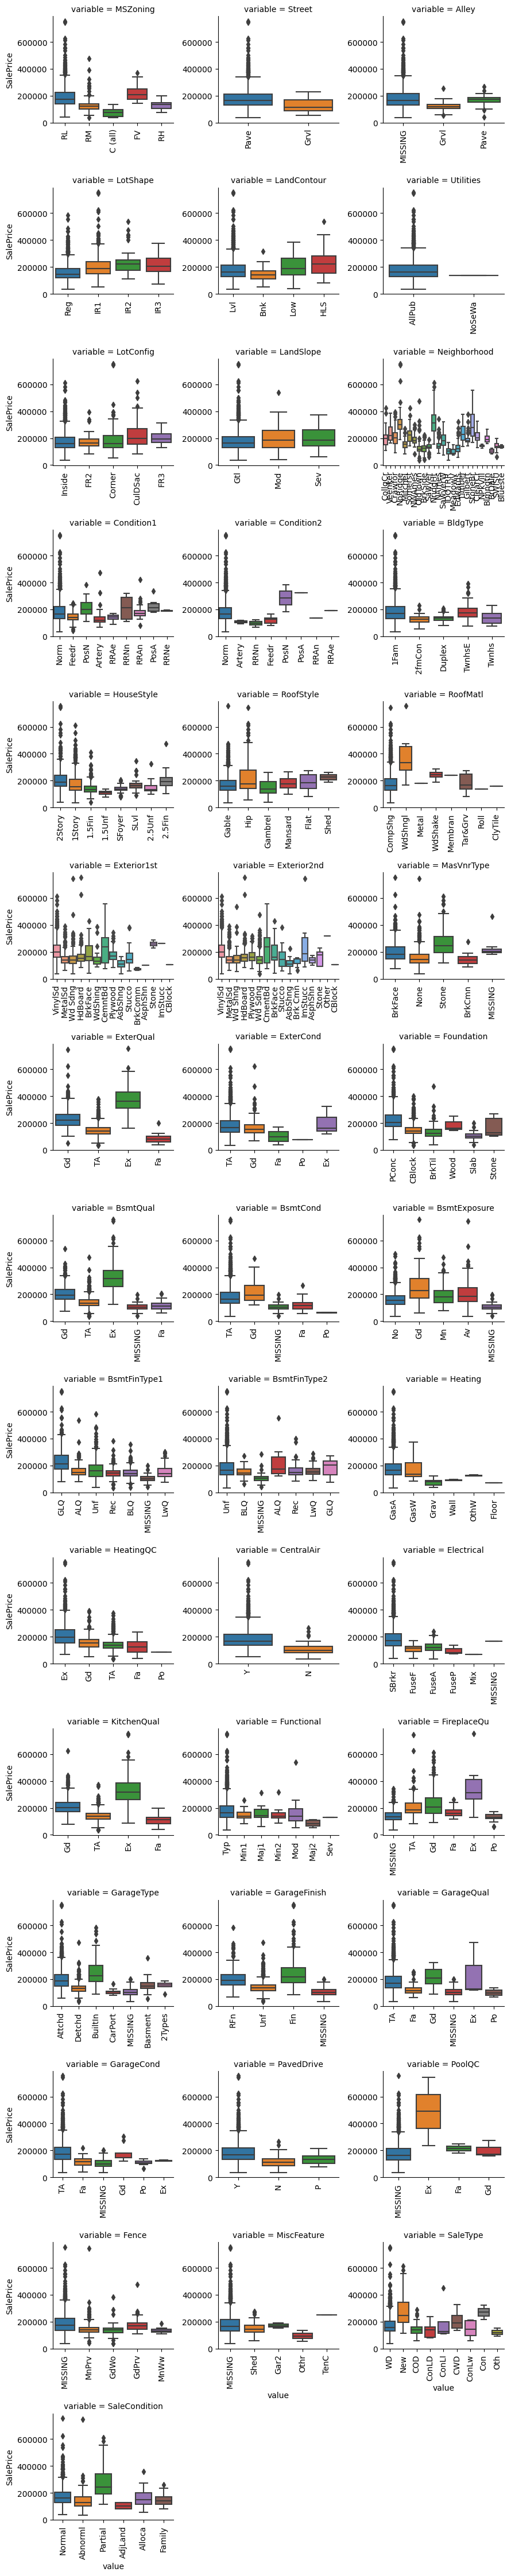

In [9]:
def custom_boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    plt.xticks(rotation=90)

# Melt the Dataframe
melted_train = pd.melt(df_train_cp, id_vars=["SalePrice"], value_vars=quanlitative)
grid = sns.FacetGrid(melted_train, col="variable", col_wrap=3, sharex=False, sharey=False)
grid = grid.map(custom_boxplot, "value", "SalePrice")

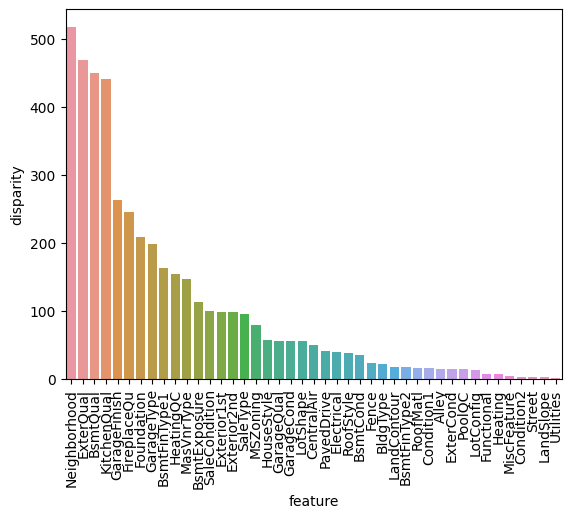

In [10]:
def anova_analysis(dataframe, quanlitative_features):
    # Create am empty DataFrame to store the ANOVA results
    anova_results = pd.DataFrame()
    anova_results['feature'] = quanlitative_features

    p_values = []

    for feature in quanlitative_features:
        samples = []
        for category in dataframe[feature].unique():
            sample_values = dataframe[dataframe[feature] == category]['SalePrice'].values
            samples.append(sample_values)

        # Perfirn a one-way ANOVA test on the samples to compare means
        p_value = st.f_oneway(*samples)[1]
        p_values.append(p_value)

    # Add the p-values to the DataFrame
    anova_results['p_value'] = p_values

    # Taking the negative natural logarithm of p_values
    anova_results['disparity'] = np.log(1.0 / anova_results['p_value'].values)
     # Sort the DataFrame based on p-values in ascending order
    anova_results = anova_results.sort_values('p_value')
    
    return anova_results

results  = anova_analysis(df_train_cp, quanlitative)
# Plot the 'disparity' values for each feature
sns.barplot(data=results, x='feature', y='disparity')
plt.xticks(rotation=90)
plt.show()

## Correlation matrix

<Axes: >

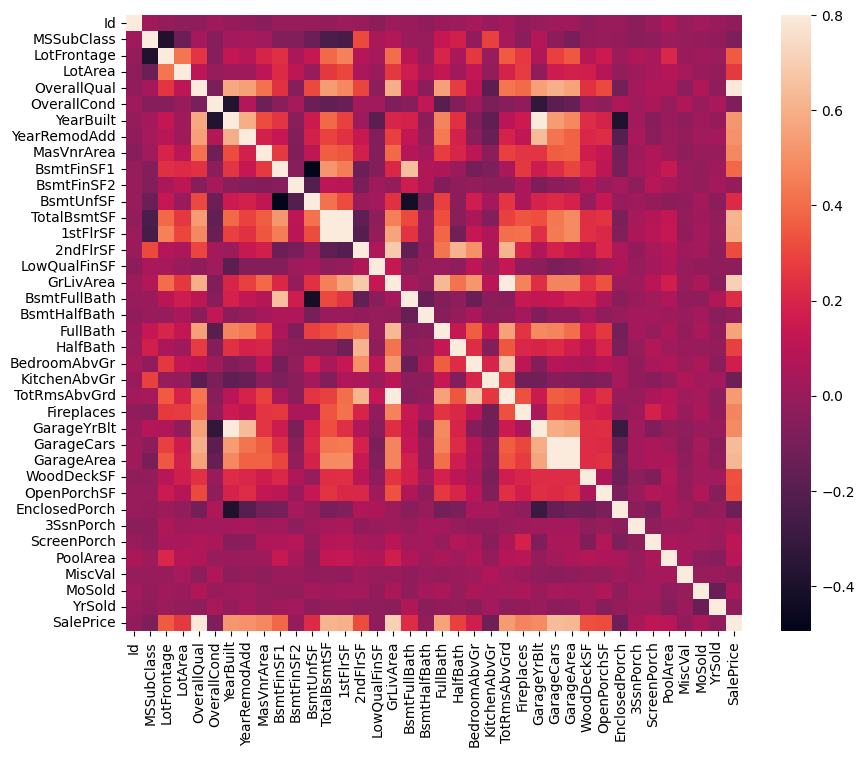

In [11]:
correlation_matrix = df_train.corr()
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(correlation_matrix, vmax=.8, square=True)

### "SalePrice" correlation matrix (zoomed heatmap style)

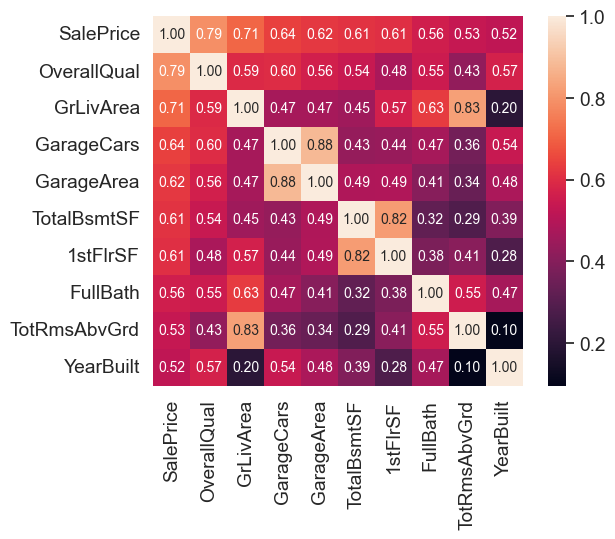

In [12]:
# SalePrice correlation matrix
k = 10
columns = correlation_matrix.nlargest(k, "SalePrice")["SalePrice"].index

# Calculate the correlation matrix for selected variables
saleprice_correlation_matrix = np.corrcoef(df_train[columns].values.T)

# Set the font scale for the heatmap
sns.set(font_scale=1.25)

# Create and display the heatmap
heatmap = sns.heatmap(saleprice_correlation_matrix,
                      cbar=True,
                      annot=True,
                      square=True,
                      fmt='.2f',
                      annot_kws={'size': 10},
                      yticklabels=columns.values,
                      xticklabels=columns.values)
plt.show()

### Scatter plots
- Scatter plots between "SalePrice" and correlated variables (move like Jagger style)

In [13]:
# sns.set()
# sns.pairplot(df_train[columns], size = 2.5)
# plt.show()

## Missing data

In [14]:
# missing data
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count() * 100).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=["Total", "Percent"])
missing_data.head(20)

,Total,Percent
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageYrBlt,81,5.547945
GarageCond,81,5.547945
GarageType,81,5.547945
GarageFinish,81,5.547945


In [15]:
df_train = df_train.drop((missing_data[missing_data["Total"] > 1]).index, 1)
df_train = df_train.drop(df_train.loc[df_train['Electrical'].isnull()].index)
df_train.isnull().sum().max()

0

## Outliers

### Univariate Analysis

In [16]:
from sklearn.preprocessing import StandardScaler

saleprice_scaled = StandardScaler().fit_transform(df_train['SalePrice'][:,np.newaxis]);
low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range= saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-1.83820775]
 [-1.83303414]
 [-1.80044422]
 [-1.78282123]
 [-1.77400974]
 [-1.62295562]
 [-1.6166617 ]
 [-1.58519209]
 [-1.58519209]
 [-1.57269236]]

outer range (high) of the distribution:
[[3.82758058]
 [4.0395221 ]
 [4.49473628]
 [4.70872962]
 [4.728631  ]
 [5.06034585]
 [5.42191907]
 [5.58987866]
 [7.10041987]
 [7.22629831]]


### Bivariate analysis

<Axes: xlabel='GrLivArea', ylabel='SalePrice'>

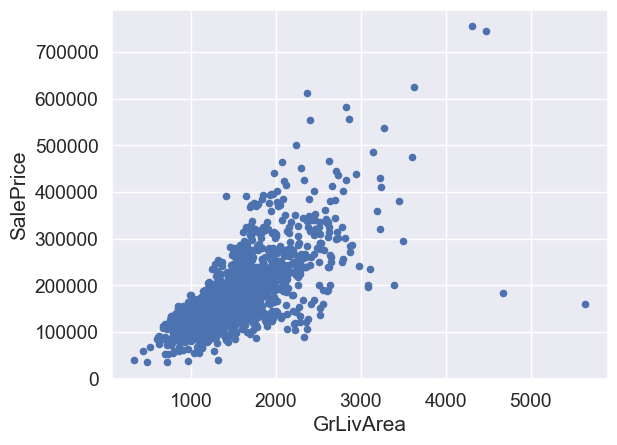

In [17]:
# GrLivArea means Above grade (ground) living area square feet
variable = "GrLivArea"
data = pd.concat([df_train["SalePrice"], df_train[variable]], axis=1)
data.plot.scatter(x=variable, y = "SalePrice")

In [18]:
#deleting points
df_train.sort_values(by = 'GrLivArea', ascending = False)[:2]
outlier_id1 = 1298
outlier_id2 = 523

df_train = df_train.drop(df_train[df_train["Id"] == (outlier_id1 + 1)].index)
df_train = df_train.drop(df_train[df_train["Id"] == (outlier_id2 + 1)].index)

<Axes: xlabel='GrLivArea', ylabel='SalePrice'>

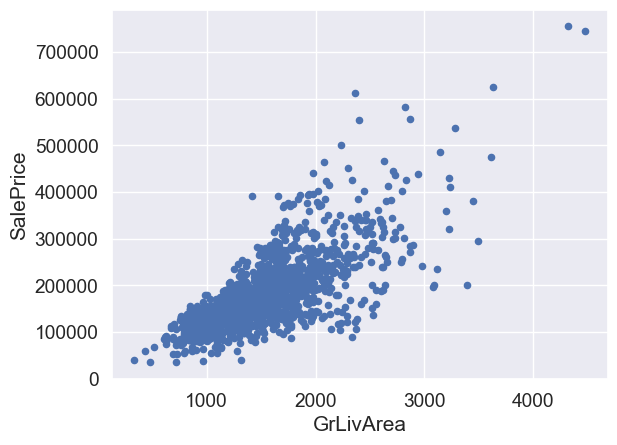

In [19]:
# GrLivArea means Above grade (ground) living area square feet
variable = "GrLivArea"
data = pd.concat([df_train["SalePrice"], df_train[variable]], axis=1)
data.plot.scatter(x=variable, y = "SalePrice")